In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from dataset import DrumPatternDataset
from hierarchical_vae import HierarchicalDrumVAE
from analyze_latent import visualize_latent_hierarchy
from analyze_latent import interpolate_styles
from analyze_latent import measure_disentanglement
from analyze_latent import controllable_generation

from torch.utils.data import DataLoader
import random

device = torch.device('mps')

In [2]:
model = HierarchicalDrumVAE(z_high_dim=4, z_low_dim=12)
model.load_state_dict(torch.load("results/best_model.pth", map_location=device))
model.to(device)
model.eval()

/var/folders/hc/52j22vds6db7v04zbb99g60m0000gn/T/ipykernel_98285/2963219396.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("results/bes

HierarchicalDrumVAE(
  (encoder_low): Sequential(
    (0): Conv1d(9, 32, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): ReLU()
    (2): Conv1d(32, 64, kernel_size=(3,), stride=(2,), padding=(1,))
    (3): ReLU()
    (4): Conv1d(64, 128, kernel_size=(3,), stride=(2,), padding=(1,))
    (5): ReLU()
    (6): Flatten(start_dim=1, end_dim=-1)
  )
  (fc_mu_low): Linear(in_features=512, out_features=12, bias=True)
  (fc_logvar_low): Linear(in_features=512, out_features=12, bias=True)
  (encoder_high): Sequential(
    (0): Linear(in_features=12, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
  )
  (fc_mu_high): Linear(in_features=32, out_features=4, bias=True)
  (fc_logvar_high): Linear(in_features=32, out_features=4, bias=True)
  (decoder_low): Sequential(
    (0): Linear(in_features=12, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=512, bias=True)
    (3): ReLU()
  )
  (

In [3]:
data_dir = '../data/drums'
dataset = DrumPatternDataset(data_dir, split='val')
data_loader = DataLoader(dataset, batch_size=32, shuffle=False)

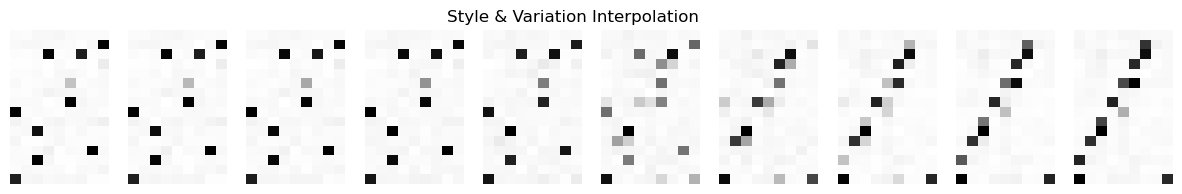

In [4]:
jazz_sample = None
rock_sample = None

for pattern, style, density in dataset:
    if style == 1 and jazz_sample is None:
        jazz_sample = pattern
    elif style == 2 and rock_sample is None:
        rock_sample = pattern
    if jazz_sample is not None and rock_sample is not None:
        break

interpolate_styles(model, jazz_sample, rock_sample, n_steps=10, device=device)


RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

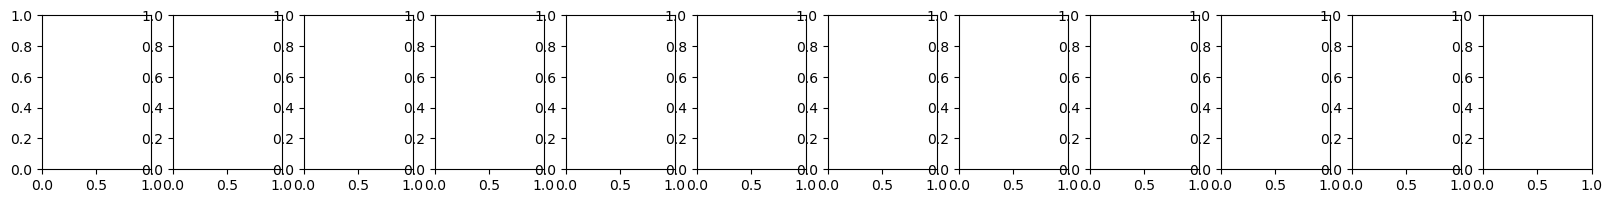

In [8]:
def control_density(model, z_high, device='cuda'):
    z_high = z_high.unsqueeze(0).repeat(12, 1).to(device)
    fig, axs = plt.subplots(1, 12, figsize=(20, 2))
    for dim in range(12):
        z_low = torch.zeros(12, 12).to(device)
        z_low[:, dim] = torch.linspace(-3, 3, 12).to(device)
        logits = model.decode_hierarchy(z_high, z_low)
        patterns = torch.sigmoid(logits).cpu().numpy()

        for i in range(12):
            axs[i].imshow(patterns[i].T, aspect='auto', cmap='Greys', origin='lower')
            axs[i].axis('off')
    plt.suptitle("Controlling Density via z_low Dimensions")
    plt.show()

# Cell 7: Run density control test
example_z_high = torch.randn(model.z_high_dim)
control_density(model, example_z_high, device)
